<a href="https://colab.research.google.com/github/nilabja10201992/Cryptocurrency-Price-Prediction/blob/ajay_branch/craptocurrency_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
# python 2
!pip install pytrends
try:
    from urllib.request import Request, urlopen  
# Python 3
except ImportError:
    from urllib2 import Request, urlopen

import pandas as pd
import time
import datetime
import numpy as np
import re
import json
from bs4 import BeautifulSoup
from pytrends.request import TrendReq

class Cryptory():
    
    def __init__(self, from_date, to_date=None, ascending=False, 
                 fillgaps=True, timeout=10.0):
        """Initialise cryptory class
        
        Parameters
        ----------
        from_date : the starting date (as string) for the returned data;
            required format is %Y-%m-%d (e.g. "2017-06-21")
        to_date : the end date (as string) for the returned data;
            required format is %Y-%m-%d (e.g. "2017-06-21")
            Optional. If unspecified, it will default to the current day
        to_date : binary. Determines whether the returned dataframes are
            ordered by date in ascending or descending order 
            (defaults to False i.e. most recent first)
        fillgaps : binary. When data does not exist (e.g. weekends for stocks)
            should the rows be filled in with the previous available data
            (defaults to True e.g. Saturday stock price will be same as Friday)
        fillgaps : float. The max time allowed (in seconds) to pull data from a website
            If exceeded, an timeout error is returned. Default is 10 seconds.
        """
        
        self.from_date = from_date
        # if to_date provided, defaults to current date
        if to_date is None:
            self.to_date = datetime.date.today().strftime("%Y-%m-%d")
        else:
            self.to_date = to_date
        self.ascending = ascending
        self.fillgaps = fillgaps
        self.timeout = timeout
        self._df = pd.DataFrame({'date':pd.date_range(start=self.from_date, end=self.to_date)})
        
    def extract_reddit_metrics(self, subreddit, metric, col_label="", sub_col=False):
        """Retrieve daily subscriber data for a specific subreddit scraped from redditmetrics.com
        
        Parameters
        ----------
        subreddit : the name of subreddit (e.g. "python", "learnpython")
        metric : the particular subscriber information to be retrieved
            (options are limited to "subscriber-growth" (daily change), 
            'total-subscribers' (total subscribers on a given day) and 
            'rankData' (the position of the subreddit on reddit overall)
            'subscriber-growth-perc' (daily percentage change in subscribers))
        col_label : specify the title of the value column
            (it will default to the metric name with hyphens replacing underscores)
        sub_col : whether to include the subreddit name as a column
            (default is False i.e. the column is not included)
            
        Returns
        -------
        pandas Dataframe
        """
        if metric not in ['subscriber-growth', 'total-subscribers', 'rankData', 'subscriber-growth-perc']:
            raise ValueError(
                "Invalid metric: must be one of 'subscriber-growth', " + 
                "'total-subscribers', 'subscriber-growth-perc', 'rankData'")
        url = "http://redditmetrics.com/r/" + subreddit
        if metric == 'subscriber-growth-perc':
            metric_name = 'total-subscribers'
        else:
            metric_name = metric
        try: 
            parsed_page = urlopen(url, timeout=self.timeout).read()
            parsed_page = parsed_page.decode("utf8")
        except:
            # future versions may split out the different exceptions (e.g. timeout)
            raise
        if metric == 'rankData':
            start_segment = parsed_page.find(metric)
        else:
            start_segment = parsed_page.find("element: '"+metric_name+"'")
        if start_segment != -1:
            start_list = parsed_page.find("[", start_segment)
            end_list = parsed_page.find("]", start_list)
            parsed_page = parsed_page[start_list:end_list + 1]
        else:
            return ValueError("Could not find that subreddit")
        parsed_page = parsed_page.replace("'", '"')
        parsed_page = parsed_page.replace('a', '\"subscriber_count\"')
        parsed_page = parsed_page.replace('y', '\"date\"')
        output = json.loads(parsed_page)
        output = pd.DataFrame(output)
        output['date'] = pd.to_datetime(output['date'], format="%Y-%m-%d")
        if metric == 'subscriber-growth-perc':
            output['subscriber_count'] = output['subscriber_count'].pct_change()
        output = output[(output['date']>=self.from_date) & (output['date']<=self.to_date)]
        output = output.sort_values(by='date', ascending=self.ascending).reset_index(drop=True)
        if sub_col:
            output['subreddit'] = subreddit
        if col_label != "":
            output = output.rename(columns={'subscriber_count': label})
        else:
            output = output.rename(columns={'subscriber_count': metric.replace("-","_")})
        return output
        
    def extract_coinmarketcap(self, coin, coin_col=False):
        """Retrieve basic historical information for a specific cryptocurrency from coinmarketcap.com
        
        Parameters
        ----------
        coin : the name of the cryptocurrency (e.g. 'bitcoin', 'ethereum', 'dentacoin')
        coin_col : whether to include the coin name as a column
            (default is False i.e. the column is not included)
            
        Returns
        -------
        pandas Dataframe
        """
        try:
            output = pd.read_html("https://coinmarketcap.com/currencies/{}/historical-data/?start={}&end={}".format(
                coin, self.from_date.replace("-", ""), self.to_date.replace("-", "")))[0]
        except:
            # future versions may split out the different exceptions (e.g. timeout)
            raise
        output = output.assign(Date=pd.to_datetime(output['Date']))
        for col in output.columns:
            if output[col].dtype == np.dtype('O'):
                output.loc[output[col]=="-",col]=0
                output[col] = output[col].astype('int64')
        output.columns = [re.sub(r"[^a-z]", "", col.lower()) for col in output.columns]
        if coin_col:
            output['coin'] = coin
        return output
    
    def extract_bitinfocharts(self, coin, metric="price", coin_col=False, metric_col=False):
        """Retrieve historical data for a specific cyrptocurrency scraped from bitinfocharts.com
        
        Parameters
        ----------
        coin : the code of the cryptocurrency (e.g. 'btc' for bitcoin)
            full range of available coins can be found on bitinfocharts.com
        metric : the particular coin information to be retrieved
            (options are limited to those listed on bitinfocharts.com
            including 'price', 'marketcap', 'transactions' and 'sentinusd'
        coin_col : whether to include the coin name as a column
            (default is False i.e. the column is not included)
        metric_col : whether to include the metric name as a column
            (default is False i.e. the column is not included)
            
        Returns
        -------
        pandas Dataframe
        """
        if coin not in ['btc', 'eth', 'xrp', 'bch', 'ltc', 'dash', 'xmr', 'btg', 'etc', 'zec', 
                        'doge', 'rdd', 'vtc', 'ppc', 'ftc', 'nmc', 'blk', 'aur', 'nvc', 'qrk', 'nec']:
            raise ValueError("Not a valid coin")
        if metric not in ['transactions', 'size', 'sentbyaddress', 'difficulty', 'hashrate', 'price', 
                          'mining_profitability', 'sentinusd', 'transactionfees', 'median_transaction_fee', 
                        'confirmationtime', 'marketcap', 'transactionvalue', 'mediantransactionvalue',
                         'tweets', 'activeaddresses', 'top100cap']:
            raise ValueError("Not a valid bitinfocharts metric")
        new_col_name = "_".join([coin, metric])
        parsed_page = Request("https://bitinfocharts.com/comparison/{}-{}.html".format(metric, coin),
                            headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11'})
        try: 
            parsed_page = urlopen(parsed_page, timeout=self.timeout).read()
            parsed_page = parsed_page.decode("utf8")
        except:
            # future versions may split out the different exceptions (e.g. timeout)
            raise
        start_segment = parsed_page.find("new Dygraph")
        if start_segment != -1:
            start_list = parsed_page.find('[[', start_segment)
            end_list = parsed_page.find(']]', start_list)
            parsed_page = parsed_page[start_list:end_list]
        else:
            raise ValueError("Could not find the appropriate text tag in the scraped page")
        parsed_page = parsed_page.replace('new Date(', '')
        parsed_page = parsed_page.replace(')', '')
        parsed_page = parsed_page.replace('null', '0')
        parsed_page = parsed_page.replace('["', '{"date":"')
        parsed_page = parsed_page.replace('",', '","{}":'.format(new_col_name))
        parsed_page = parsed_page.replace('],', '},')
        parsed_page = parsed_page + '}]'
        output = json.loads(parsed_page)
        output = pd.DataFrame(output)
        output['date'] = pd.to_datetime(output['date'], format="%Y-%m-%d")
        output = output[(output['date']>=self.from_date) & (output['date']<=self.to_date)]
        # for consistency, put date column first
        output = output[['date', new_col_name]]
        if coin_col:
            output['coin'] = coin
        if metric_col:
            output['metric'] = metric
        return output.sort_values(by='date', ascending=self.ascending).reset_index(drop=True)
    
    def extract_poloniex(self, coin1, coin2, coin1_col=False, coin2_col=False):
        """Retrieve the historical price of one coin relative to another (currency pair) from poloniex
        
        Parameters
        ----------
        coin1 : the code of the denomination cryptocurrency 
            (e.g. 'btc' for prices in bitcoin)
        coin2 : the code for the coin for which prices are retrieved
            (e.g. 'eth' for ethereum)
        coin1_col : whether to include the coin1 code as a column
            (default is False i.e. the column is not included)
        coin2_col : whether to include the coin2 code as a column
            (default is False i.e. the column is not included)
            
        Returns
        -------
        pandas Dataframe
        """
            
        from_date = int(time.mktime(time.strptime(self.from_date, "%Y-%m-%d")))
        to_date = int(time.mktime(time.strptime(self.to_date, "%Y-%m-%d")))
        url = "https://poloniex.com/public?command=returnChartData&currencyPair={}_{}&start={}&end={}&period=86400".format(
                coin1.upper(), coin2.upper(), from_date, to_date)
        try: 
            parsed_page = urlopen(url, timeout=self.timeout).read()
            parsed_page = parsed_page.decode("utf8")
        except:
            # future versions may split out the different exceptions (e.g. timeout)
            raise
        output = json.loads(parsed_page)
        if isinstance(output, dict):
            if 'error' in list(output.keys()):
                raise ValueError("The content of the page was not as it should be")
        output = pd.DataFrame(output)
        # more intuitive column order
        output = output[['date', 'close', 'open', 'high', 'low', 
                        'weightedAverage', 'quoteVolume', 'volume']]
        output['date'] = pd.to_datetime(output['date'], unit='s')
        output = output.sort_values(by='date', ascending=self.ascending).reset_index(drop=True)
        if coin1_col:
            output['coin1'] = coin1
        if coin2_col:
            output['coin2'] = coin2
        return output
    
    def get_exchange_rates(self, from_currency="USD", to_currency="EUR", 
                                 from_col=False, to_col=False):
        """Retrieve the historical exchange rate between two (fiat) currencies
        
        Parameters
        ----------
        from_currency : the from currency or the currency of denomination (e.g. 'USD')
        to_currency : the currency to which you wish to exchange (e.g. 'EUR')
        from_col : whether to include the from_currency code as a column
            (default is False i.e. the column is not included)
        to_col : whether to include the to_currency code as a column
            (default is False i.e. the column is not included)
            
        Returns
        -------
        pandas Dataframe
        """
        n_days = (datetime.date.today() - 
                  datetime.datetime.strptime(self.from_date, "%Y-%m-%d").date()).days + 1
        url = "https://www.indexmundi.com/xrates/graph.aspx?c1={}&c2={}&days={}".format(
            from_currency, to_currency, n_days)
        try: 
            parsed_page = urlopen(url, timeout=self.timeout).read()
            parsed_page = parsed_page.decode("utf8")
        except:
            # future versions may split out the different exceptions (e.g. timeout)
            raise
        start_segment = parsed_page.find("chart xAxisName")
        if start_segment != -1:
            start_list = parsed_page.find("<", start_segment)
            end_list = parsed_page.find("/></chart>", start_list)
            parsed_page = parsed_page[start_list:end_list]
        else:
            raise ValueError("Could not find the appropriate text tag in the scraped page")
        parsed_page = re.sub(r" showLabel='[0-9]'", "", parsed_page)
        parsed_page = parsed_page.replace("'", '"')
        parsed_page = parsed_page.replace("set ", '')
        parsed_page = parsed_page.replace("<", "{")
        parsed_page = parsed_page.replace("/>", "},")
        parsed_page = parsed_page.replace('label', '\"date\"')
        parsed_page = parsed_page.replace('value', '\"exch_rate\"')
        parsed_page = parsed_page.replace('=', ':')
        parsed_page = parsed_page.replace(' ', ',')
        output = json.loads('[' + parsed_page + '}]')
        output = pd.DataFrame(output)
        output['date'] = pd.to_datetime(output['date'], format="%m/%d/%Y")
        output['exch_rate'] = pd.to_numeric(output['exch_rate'], errors='coerce')
        if from_col:
            output['from_currency'] = from_currency
        if to_col:
            output['to_currency'] = to_currency
        output = self._merge_fill_filter(output)
        return output
    
    def get_stock_prices(self, market, market_name=None):
        """Retrieve the historical price (or value) of a publically listed stock or index
        
        Parameters
        ----------
        market : the code of the stock or index (see yahoo finance for examples)
            ('%5EDJI' refers to the Dow Jones and '%5EIXIC' pulls the Nasdaq index)
        market_name : specify an appropriate market name or label (under the market_name column)
            the default is None (default is None i.e. the column is not included)
            
        Returns
        -------
        pandas Dataframe
        
        Notes
        -----
        This method scrapes data from yahoo finance, so it only works when the historical
        data is presented on the site (which is not the case for a large number of stocks/indices).
        """
        from_date = int(time.mktime(time.strptime(self.from_date, "%Y-%m-%d")))
        # we want the daily data
        # this site works off unix time (86400 seconds = 1 day)
        to_date = int(time.mktime(time.strptime(self.to_date, "%Y-%m-%d"))) + 86400
        url = "https://finance.yahoo.com/quote/{}/history?period1={}&period2={}&interval=1d&filter=history&frequency=1d".format(
        market, from_date,  to_date)
        try: 
            parsed_page = urlopen(url, timeout=1).read()
            parsed_page = parsed_page.decode("utf8")
        except:
            # future versions may split out the different exceptions (e.g. timeout)
            raise
        start_segment = parsed_page.find('{\"prices\":')
        if start_segment != -1:
            start_list = parsed_page.find("[", start_segment)
            end_list = parsed_page.find("]", start_list)
            parsed_page = parsed_page[start_list:end_list+1]
        else:
            raise ValueError("Could not find the appropriate text tag in the scraped page")
        output = json.loads(parsed_page)
        output = pd.DataFrame(output)
        output['date'] = pd.to_datetime(output['date'],unit='s').apply(lambda x: x.date())
        output['date'] = pd.to_datetime(output['date'])
        # dividends mess up the dataframe
        if 'amount' in output.columns:
            output = output[pd.isnull(output['amount'])]
            output = output.drop(columns=['amount', 'data', 'type'])
        if market_name is not None:
            output['market_name'] = market_name
        output = self._merge_fill_filter(output)
        return output
    
    def get_oil_prices(self):
        """Retrieve the historical oil price (London Brent crude)
        
        Parameters
        ----------
            
        Returns
        -------
        pandas Dataframe
        
        Notes
        -----
        This site seems to take significantly longer than the others to scrape
        If you get timeout errors, then increase the timeout argument when
        you initalise the cryptory class
        """
        try: 
            parsed_page = urlopen("https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=RWTC&f=D",
                                          timeout=self.timeout).read()
            parsed_page = parsed_page.decode("utf8")
        except:
            # future versions may split out the different exceptions (e.g. timeout)
            #return pd.DataFrame({"error":e}, index=[0])
            raise
        souped_page = BeautifulSoup(parsed_page, 'html.parser')
        souped_values = [soups.text for soups in souped_page.findAll("td", {"class": "B3"})]
        souped_dates = [datetime.datetime.strptime(
                re.sub('\xa0\xa0| to .*','', soups.text), '%Y %b-%d') 
                        for soups in souped_page.findAll("td", {"class": "B6"})]
        output = []
        for i in range(5):
            output.append(pd.DataFrame({"date":[date + datetime.timedelta(days=i) 
                                                for date in souped_dates],
                           "oil_price":souped_values[i::5]}))
        output = pd.concat(output)
        output.loc[output['oil_price']=="",'oil_price']=np.nan
        output['oil_price'] = pd.to_numeric(output['oil_price'])
        output = self._merge_fill_filter(output)
        return output
    
    def get_metal_prices(self):
        """Retrieve the historical price of gold, silver, platinum and palladium
        
        Parameters
        ----------
            
        Returns
        -------
        pandas Dataframe
        """
            
        current_year = datetime.datetime.now().year
        from_year = datetime.datetime.strptime(self.from_date, "%Y-%m-%d").year
        to_year = datetime.datetime.strptime(self.to_date, "%Y-%m-%d").year
        if to_year is None:
            to_year = current_year
        output = []
        for i in range(from_year, to_year+1):
            if i==current_year:
                output.append(pd.read_html("http://www.kitco.com/gold.londonfix.html")[-1])
            else:
                output.append(pd.read_html("http://www.kitco.com/londonfix/gold.londonfix"+
                                       str(i)[-2:]+".html")[-1])
        output = pd.concat(output).dropna()
        output.columns = ['date', 'gold_am', 'gold_pm','silver', 'platinum_am', 
                          'platinum_pm', 'palladium_am', 'palladium_pm']
        output = output.assign(date=pd.to_datetime(output['date']))
        for col in output.select_dtypes(include=['object']):
            output.loc[output[col]=="-",col]=np.nan
            output[col] = output[col].astype('float64')
        output = pd.merge(self._df, output, on="date", how="left")
        if self.fillgaps:
            for old_val, new_val in zip(['gold_am', 'gold_pm', 'platinum_am', 'platinum_pm',
                                         'palladium_am', 'palladium_pm'],
                                       ['gold_pm', 'gold_am', 'platinum_pm', 'platinum_am',
                                         'palladium_pm', 'palladium_am']):
                output.loc[output[old_val].isnull(), old_val]= output.loc[output[old_val].isnull(), 
                                                                          new_val]
            output = output.fillna(method='ffill')
        output = output.sort_values(by='date', ascending=self.ascending).reset_index(drop=True)
        output = output[(output['date']>=self.from_date) & (output['date']<=self.to_date)]
        return output
    
    def get_google_trends(self, kw_list, trdays=250, overlap=100, 
                          cat=0, geo='', tz=360, gprop='', hl='en-US',
                          sleeptime=1, isPartial_col=False, 
                          from_start=False, scale_cols=True):
        """Retrieve daily google trends data for a list of search terms
        
        Parameters
        ----------
        kw_list : list of search terms (max 5)- see pyTrends for more details
        trdays : the number of days to pull data for in a search
            (the max is around 270, though the website seems to indicate 90)
        overlap : the number of overlapped days when stitching two searches together
        cat : category to narrow results - see pyTrends for more details
        geo : two letter country abbreviation (e.g 'US', 'UK') 
            default is '', which returns global results - see pyTrends for more details
        tz : timezone offset
            (default is 360, which corresponds to US CST - see pyTrends for more details)
        grop : filter results to specific google property
            available options are 'images', 'news', 'youtube' or 'froogle'
            default is '', which refers to web searches - see pyTrends for more details
        hl : language (e.g. 'en-US' (default), 'es') - see pyTrends for more details
        sleeptime : when stiching multiple searches, this sets the period between each
        isPartial_col : remove the isPartial column 
            (default is True i.e. column is removed)
        from_start : when stitching multiple results, this determines whether searches
            are combined going forward or backwards in time
            (default is False, meaning searches are stitched with the most recent first)
        scale_cols : google trend searches traditionally returns scores between 0 and 100
            stitching could produce values greater than 100
            by setting this to True (default), the values will range between 0 and 100
        
        Returns
        -------
        pandas Dataframe
        
        Notes
        -----
        This method is essentially a highly restricted wrapper for the pytrends package
        Any issues/questions related to its use would probably be more likely resolved
        by consulting the pytrends github page
        https://github.com/GeneralMills/pytrends
        """
        
        if len(kw_list)>5 or len(kw_list)==0:
            raise ValueError("The keyword list can contain at most 5 words")
        if trdays>270:
            raise ValueError("trdays must not exceed 270")
        if overlap>=trdays:
            raise ValueError("Overlap can't exceed search days")
        stich_overlap = trdays - overlap
        from_date = datetime.datetime.strptime(self.from_date, '%Y-%m-%d')
        to_date = datetime.datetime.strptime(self.to_date, '%Y-%m-%d')
        n_days = (to_date - from_date).days
        # launch pytrends request
        _pytrends = TrendReq(hl=hl, tz=tz)
        # get the dates for each search
        if n_days <= trdays:
            trend_dates = [' '.join([self.from_date, self.to_date])]
        else:
            trend_dates = ['{} {}'.format(
            (to_date - datetime.timedelta(i+trdays)).strftime("%Y-%m-%d"),
            (to_date - datetime.timedelta(i)).strftime("%Y-%m-%d")) 
                           for i in range(0,n_days-trdays+stich_overlap,
                                          stich_overlap)]
        if from_start:
            trend_dates = trend_dates[::-1]
        try:
            _pytrends.build_payload(kw_list, cat=cat, timeframe=trend_dates[0], 
                                   geo=geo, gprop=gprop)
        except:
            raise
        output = _pytrends.interest_over_time().reset_index()
        if len(output)==0:
            raise ValueError('search term returned no results (insufficient data)')
        for date in trend_dates[1:]:
            time.sleep(sleeptime)
            try:
                _pytrends.build_payload(kw_list, cat=cat, timeframe=date, 
                                         geo=geo, gprop=gprop)
            except:
                raise
            temp_trend = _pytrends.interest_over_time().reset_index()
            temp_trend = temp_trend.merge(output, on="date", how="left")
            # it's ugly but we'll exploit the common column names
            # and then rename the underscore containing column names
            for kw in kw_list:
                norm_factor = np.ma.masked_invalid(temp_trend[kw+'_y']/temp_trend[kw+'_x']).mean()
                temp_trend[kw] = temp_trend[kw+'_x'] * norm_factor
            temp_trend =  temp_trend[temp_trend.isnull().any(axis=1)]
            temp_trend['isPartial'] = temp_trend['isPartial_x']
            output = pd.concat([output, temp_trend[['date', 'isPartial'] + kw_list]], axis=0, sort=False)
        
        # reorder columns in alphabetical order
        output = output[['date', 'isPartial']+kw_list]
        
        if not isPartial_col:
            output = output.drop('isPartial', axis=1)
        output = output[output['date']>=self.from_date]
        if scale_cols:
            # the values in each column are relative to other columns
            # so we need to get the maximum value across the search columns
            max_val = float(output[kw_list].values.max())
            for col in kw_list:
                output[col] = 100.0*output[col]/max_val
        output = output.sort_values('date', ascending=self.ascending).reset_index(drop=True)
        return output

    
    def _merge_fill_filter(self, other_df):
        output = pd.merge(self._df, other_df, on="date", how="left")
        output = output.sort_values(by='date', ascending=self.ascending).reset_index(drop=True)
        if self.fillgaps:
            if self.ascending:
                output = output.fillna(method='ffill')
            else:
                output = output.fillna(method='bfill')
        output = output[(output['date']>=self.from_date) & (output['date']<=self.to_date)]
        return output

In [0]:
my_cryptory = Cryptory(from_date="2017-01-01")

In [0]:
import pandas as pd

pd.options.display.max_rows = 6

In [15]:
my_cryptory.extract_coinmarketcap("bitcoin")


,date,open,high,low,close,volume,marketcap
0,2019-04-28,5271.75,5326.23,5255.68,5285.14,12819992056,93391244395
1,2019-04-27,5279.47,5310.75,5233.64,5268.29,13111274675,93086156556
2,2019-04-26,5210.30,5383.63,5177.37,5279.35,16812108040,93272287960
...,...,...,...,...,...,...,...
845,2017-01-03,1021.60,1044.08,1021.60,1043.84,185168000,16786368910
846,2017-01-02,998.62,1031.39,996.70,1021.75,222184992,16429024775
847,2017-01-01,963.66,1003.08,958.70,998.33,147775008,16050407461


In [16]:
# get prices from bitinfocharts
my_cryptory.extract_bitinfocharts("btc")

,date,btc_price
0,2019-04-29,5276.000
1,2019-04-28,5260.000
2,2019-04-27,5252.000
...,...,...
846,2017-01-03,1017.000
847,2017-01-02,1010.000
848,2017-01-01,970.988


Those cells illustrate how to pull bitcoin prices from coinmarketcap and bitinfocharts. The discrepancy in prices returned by each can be explained by their different approaches to calculate daily prices (e.g. bitinfocharts represents the average prices across that day). For that reason, I wouldn't recommend combining different price sources.

You also pull non-price specific data with extract_bitinfocharts e.g. transactions fees. See help(Cryptory.extract_bitinfocharts) for more information.

In [17]:
my_cryptory.extract_bitinfocharts("eth", metric='transactionfees')


,date,eth_transactionfees
0,2019-04-28,0.07350
1,2019-04-27,0.07380
2,2019-04-26,0.09590
...,...,...
845,2017-01-03,0.00773
846,2017-01-02,0.00580
847,2017-01-01,0.00537


You may have noticed that each method returns a pandas dataframe. In fact, all cryptory methods return a pandas dataframe. This is convenient, as it allows you to slice and dice the output using common pandas techniques. For example, we can easily merge two extract_bitinfocharts calls to combine daily bitcoin and ethereum prices.

In [18]:
my_cryptory.extract_bitinfocharts("btc").merge(
my_cryptory.extract_bitinfocharts("eth"), on='date', how='inner')

,date,btc_price,eth_price
0,2019-04-29,5276.000,157.509
1,2019-04-28,5260.000,157.867
2,2019-04-27,5252.000,157.234
...,...,...,...
846,2017-01-03,1017.000,8.811
847,2017-01-02,1010.000,8.182
848,2017-01-01,970.988,8.233


One further source of crypto prices is offered by extract_poloniex, which pulls data from the public poloniex API. For example, we can retrieve the BTC/ETH exchange rate.

In [19]:
my_cryptory.extract_poloniex(coin1="btc", coin2="eth")


,date,close,open,high,low,weightedAverage,quoteVolume,volume
0,2019-04-29,0.029825,0.029757,0.029885,0.029680,0.029782,1.269901e+03,37.819700
1,2019-04-28,0.029712,0.030080,0.030140,0.029706,0.029919,9.493835e+03,284.047059
2,2019-04-27,0.030090,0.029730,0.030380,0.029614,0.029847,1.023264e+04,305.418569
...,...,...,...,...,...,...,...,...
846,2017-01-03,0.009280,0.008218,0.009750,0.008033,0.009084,1.376059e+06,12499.794908
847,2017-01-02,0.008220,0.008199,0.008434,0.007823,0.008101,6.372636e+05,5162.784640
848,2017-01-01,0.008200,0.008335,0.008931,0.008001,0.008471,7.046517e+05,5968.975870


In [24]:
all_coins_df = my_cryptory.extract_bitinfocharts("btc")
bitinfocoins = ['btc', 'eth', 'xrp', 'bch', 'ltc', 'dash', 'xmr', 'etc', 'zec', 'doge', 'rdd', 'vtc', 'ftc', 'nmc', 'blk', 'nvc']
for coin in bitinfocoins[1:]:
    all_coins_df = all_coins_df.merge(my_cryptory.extract_bitinfocharts(coin), on="date", how="left")
    print coin


eth
xrp
bch
ltc
dash
xmr
etc
zec
doge
rdd
vtc
ftc
nmc
blk
nvc


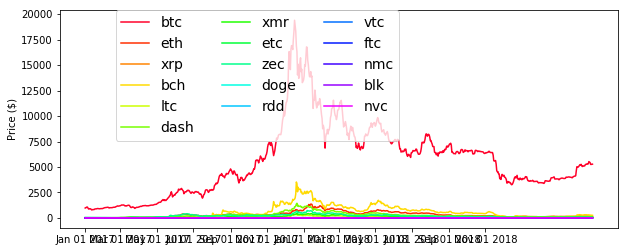

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

fig, ax1 = plt.subplots(1, 1, figsize=(10, 4))

cm = plt.get_cmap('gist_rainbow')

ax1.set_xticks([datetime.date(j,i,1) for i in range(1,13,2) for j in range(2017, 2019)])
ax1.set_xticklabels([datetime.date(j,i,1).strftime('%b %d %Y') for i in range(1,13,2) for j in range(2017, 2019)])
for coin,color in zip(bitinfocoins, [cm(1.*i/len(bitinfocoins)) for i in range(len(bitinfocoins))]):
    ax1.plot(all_coins_df['date'].dt.date,all_coins_df[coin+'_price'], label=coin, color=color)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., ncol=3, prop={'size': 14})
ax1.set_ylabel('Price ($)')
plt.show()

Of course, that graph is meaningless. You can't just compare the price for single units of each coin. You need to consider the total supply and the market cap. It's like saying the dollar is undervalued compared to the Japanese Yen. But I probably shouldn't worry. It's not as if people are buying cryptos based on them being superficially cheap. More relevant here is the relative change in price since the start of 2017, which we can plot quite easily with a little pandas magic (pct_change).

In [0]:
# replace all columns (excet date) with percentage change
all_coins_df.iloc[:,1:] = all_coins_df.iloc[:,1:].divide(all_coins_df.iloc[-5:,1:].mean(), axis=1)

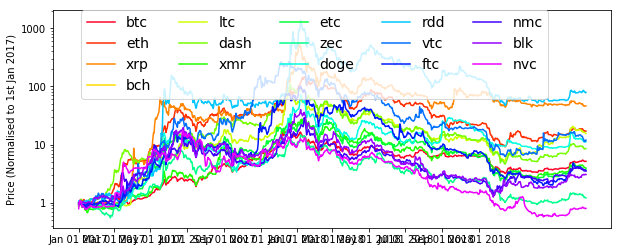

In [28]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
import numpy as np

fig, ax1 = plt.subplots(1, 1, figsize=(10, 4))

cm = plt.get_cmap('gist_rainbow')

ax1.set_xticks([datetime.date(j,i,1) for i in range(1,13,2) for j in range(2017, 2019)])
ax1.set_xticklabels([datetime.date(j,i,1).strftime('%b %d %Y') for i in range(1,13,2) for j in range(2017, 2019)])
for coin,color in zip(bitinfocoins, [cm(1.*i/len(bitinfocoins)) for i in range(len(bitinfocoins))]):
    ax1.plot(all_coins_df['date'].dt.date, all_coins_df[coin+'_price'].replace(to_replace=0, method='ffill'),label=coin, color=color)
ax1.set_yscale('log')
# via https://stackoverflow.com/questions/21920233/matplotlib-log-scale-tick-label-number-formatting
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: (
            '{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax1.legend(bbox_to_anchor=(0.05, 1), loc=2, borderaxespad=0., ncol=5, prop={'size': 14})
ax1.set_ylabel('Price (Normalised to 1st Jan 2017)')
plt.show()

Those coins are provided on bitinfocharts and they tend to represent older legacy coins. For example, the coin from this list that performed best over 2017 was Reddcoin. It started 2017 with a market cap of less than 1 million dollars, but finished it with a value of around $250m, reaching a peak of over 750m in early Jan 2018. You'll notice that each coin shows the same general behaviour- a sustained rise between March and June, followed by another spike in December and a noticeable sell-off in Jan 2018.

With a little help from pandas, we can produce a crypto price correlation plot (use the dropdown menu to switch between Pearson and Spearman correlation).

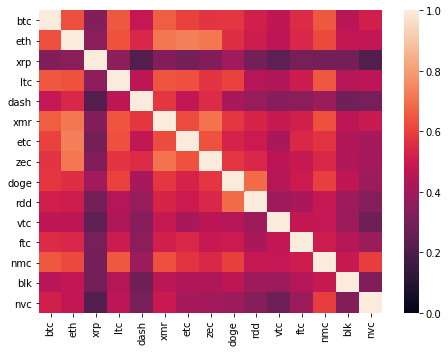

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = all_coins_df.iloc[:,1:].pct_change().corr(method='pearson')
corr = corr.dropna(axis=0, how='all').dropna(axis=1, how='all')
plt.figure(figsize=(6.7, 5))
sns.heatmap(corr,xticklabels=[col.replace("_price", "") for col in corr.columns.values],yticklabels=[col.replace("_price", "") for col in corr.columns.values], vmin=0, vmax=1)
plt.tight_layout()
plt.show()

Reddit Metrics
If you're familiar with cryptos, you're very likely to be aware of their associated reddit pages. It's where crypto investors come to discuss the merits of different blockchain implementations, dissect the day's main talking points and post amusing gifs- okay, it's mostly just GIFs. With cryptory you can combine reddit metrics (total number of subscribers, new subscribers, rank -literally scraped from the redditmetrics website) and other crypto data.

Let's take a look at iota and eos; two coins that emerged in June 2017 and experienced strong growth towards the end of 2017. Their corresponding subreddits are r/iota and r/eos, respectively.

In [30]:
my_cryptory.extract_reddit_metrics("iota", "subscriber-growth")


,date,subscriber_growth
0,2019-01-17,-5
1,2019-01-16,-7
2,2019-01-15,-7
...,...,...
746,2017-01-03,0
747,2017-01-02,0
748,2017-01-01,0


In [31]:
my_cryptory.extract_reddit_metrics("eos", "subscriber-growth")


,date,subscriber_growth
0,2019-01-17,20
1,2019-01-16,19
2,2019-01-15,19
...,...,...
746,2017-01-03,0
747,2017-01-02,0
748,2017-01-01,0


Now we can investigate the relationship between price and subreddit growth.



In [0]:
iota_df = my_cryptory.extract_reddit_metrics("iota", "subscriber-growth").merge(
my_cryptory.extract_coinmarketcap("iota"), on="date", how="inner")

iota_df = iota_df[['date', 'subscriber_growth', 'close']]
iota_df[['subscriber_growth', 'close']] = (
    iota_df[['subscriber_growth', 'close']]-iota_df[['subscriber_growth', 'close']].min())/(
    iota_df[['subscriber_growth', 'close']].max()-iota_df[['subscriber_growth', 'close']].min())

cardano_df = my_cryptory.extract_reddit_metrics("eos", "subscriber-growth").merge(
my_cryptory.extract_coinmarketcap("eos"), on="date", how="inner")

cardano_df = cardano_df[['date', 'subscriber_growth', 'close']]
cardano_df[['subscriber_growth', 'close']] = (
    cardano_df[['subscriber_growth', 'close']]-cardano_df[['subscriber_growth', 'close']].min())/(
    cardano_df[['subscriber_growth', 'close']].max()-cardano_df[['subscriber_growth', 'close']].min())

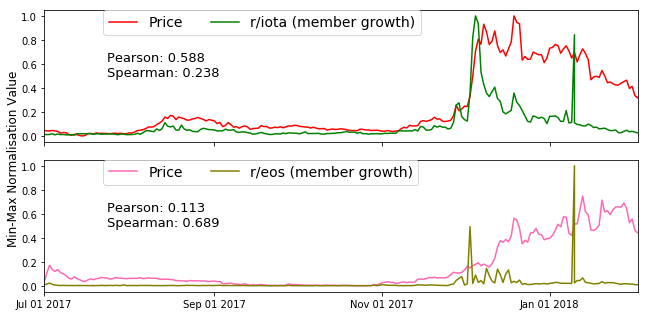

In [35]:
import matplotlib.dates as mdates

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 4.5))

for ax in [ax1, ax2]:
    ax.set_xticks([datetime.date(j,i,1) for i in range(1,13,2) for j in range(2017,2019)])

ax1.set_xticklabels([])
ax2.set_xticklabels([datetime.date(j,i,1).strftime('%b %d %Y') for i in range(1,13,2) for j in range(2017,2019)])
ax1.plot(iota_df['date'].dt.date,iota_df['close'], label='Price', color='r')
ax1.plot(iota_df['date'].dt.date, iota_df['subscriber_growth'], label='r/iota (member growth)', color='green')
ax2.plot(cardano_df['date'].dt.date, cardano_df['close'], label='Price', color='#FF69B4')
ax2.plot(cardano_df['date'].dt.date,cardano_df['subscriber_growth'], label='r/eos (member growth)', color='#808000')
for df,ax in zip([iota_df, cardano_df], [ax1, ax2]):
    ax.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., ncol=2, prop={'size': 14})
    ax.set_xlim([datetime.date(2017, 7, 1), datetime.date(2018, 2, 2)])
    ax.text(x=mdates.date2num(datetime.date(2017, 7, 24)), y=0.5, fontsize=13,s='Pearson: {}\nSpearman: {}'.format(round(df['close'].corr(df['subscriber_growth'],method='pearson'),3),round(df['close'].corr(df['subscriber_growth'],method='spearman'),3)))
fig.text(0.005, 0.5, 'Min-Max Normalisation Value', va='center', rotation='vertical',fontsize=12)
plt.tight_layout()
plt.savefig("crypto_reddit_price.png")
plt.show()

Visually speaking, there's clearly some correlation between price and subreddit member growth (the y-axis was normalised using the conventional min-max scaling). While the Spearman rank correlation is similarly high for both coins, the Pearson correlation coefficient is significantly stronger for iota, highlighting the importance of not relying on one single measure. At the time of writing, iota and eos both had a marketcap of about \$5bn (11th and 9th overall), though the number of subscribers to the iota subreddit was over 3 times more than the eos subreddit (105k and 30k, respectively). While this doesn't establish whether the relationship between price and reddit is predictive or reactive, it does suggest that reddit metrics could be useful model features for some coins.



** Google Trends **

You'll notice an almost simultaneous spike in suscribers to the iota and eos subreddits in late November and early December. This was part of a wider crypto trend, where most coins experienced unprecendented gains. Leading the charge was Bitcoin, which tripled in price between November 15th and December 15th. As the most well known crypto to nocoiners, Bitcoin (and the wider blockchain industry) received considerable mainstream attention during this bull run. Presumably, this attracted quite alot of new crypto investors (i.e gamblers), which propelled the price even higher. Well, what's the first thing you're gonna do after reading an article about this fancy futuristic blockchain that's making people rich?. You'd google bitcoin, ethereum and obviously bitconnect.

With cryptory, you can easily combine conventional crypto metrics with Google Trends data. You just need to decide the terms you want to search. It's basically a small wrapper on top of the pytrends package. If you've used Google Trends before, you'll be aware that you can only retrieve daily scores for max 90 day periods. The get_google_trends method stitches together overlapping searches, so that you can pull daily scores going back years. It's probably best to illustrate it with a few examples.

In [36]:
my_cryptory.get_google_trends(kw_list=['bitcoin'])

,date,bitcoin
0,2019-04-26,6.017192
1,2019-04-25,5.891834
2,2019-04-24,6.142551
...,...,...
843,2017-01-03,4.111046
844,2017-01-02,4.439930
845,2017-01-01,2.631070


Now we can investigate the relationship between crypto price and google search popularity.



In [0]:
btc_google = my_cryptory.get_google_trends(kw_list=['bitcoin']).merge(my_cryptory.extract_coinmarketcap('bitcoin')[['date','close']], on='date', how='inner')

eth_google = my_cryptory.get_google_trends(kw_list=['ethereum']).merge(my_cryptory.extract_coinmarketcap('ethereum')[['date','close']], on='date', how='inner')

verge_google = my_cryptory.get_google_trends(kw_list=['verge']).merge(my_cryptory.extract_coinmarketcap('verge')[['date','close']], on='date', how='inner')

In [0]:
for df,search_term in zip([btc_google, eth_google, verge_google], 
                          ['bitcoin', 'ethereum', 'verge']):
    df[[search_term,'close']] = (
        df[[search_term, 'close']]-df[[search_term, 'close']].min())/(
        df[[search_term, 'close']].max()-df[[search_term, 'close']].min())

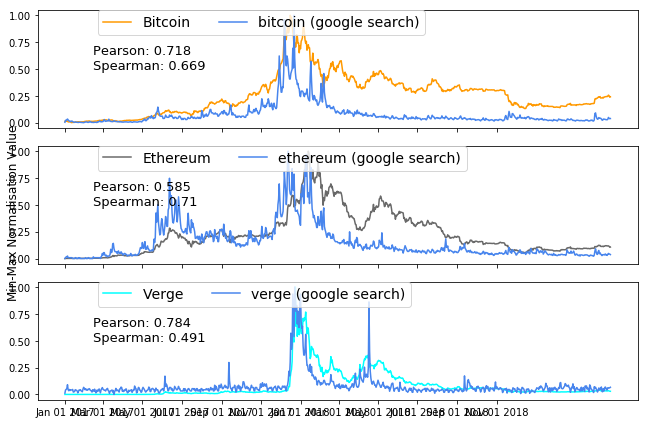

In [42]:
import matplotlib.dates as mdates

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 6))

for ax in [ax1, ax2, ax3]:
    ax.set_xticks([datetime.date(j,i,1) for i in range(1,13,2) for j in range(2017,2019)])

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([datetime.date(j,i,1).strftime('%b %d %Y') for i in range(1,13,2) for j in range(2017,2019)])
for ax,df,search_term, coin, pcol, gcol in zip([ax1, ax2, ax3],[btc_google, eth_google, verge_google], 
                                               ['bitcoin', 'ethereum', 'verge'],
                                               ['Bitcoin', 'Ethereum', 'Verge'], 
                                               ['#FF9900', '#696969', '#00FFFF'],
                                               ['#4885ed', '#4885ed', '#4885ed']):
    ax.plot(df['date'].dt.date,
             df['close'], label=coin, color=pcol)
    ax.plot(df['date'].dt.date,df[search_term], label="{} (google search)".format(search_term), color=gcol)
    ax.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., ncol=2, prop={'size': 14})
    ax.text(x=mdates.date2num(datetime.date(2017, 2, 13)), y=0.5, fontsize=13,s='Pearson: {}\nSpearman: {}'.format(round(df['close'].corr(df[search_term],method='pearson'),3),round(df['close'].corr(df[search_term],method='spearman'),3)))
fig.text(0.005, 0.5, 'Min-Max Normalisation Value', va='center', rotation='vertical',fontsize=12)
plt.tight_layout()
plt.show()


As before, it's visually obvious and statisically clear that there's a strong correlation between google searches and coin prices. Again, this a well known observation (here, here and here). What's not so apparent is whether google search drives or follows the price. That chicken and egg question question will be addressed in my next deep learning post.

A few words on Verge (xvg): eccentric (i.e. crazy) crypto visionary John McAfee recommended (i.e. shilled) the unheralded Verge to his twitter followers (i.e. fools), which triggered a huge surge in its price. As is usually the case with pump and dumps, the pump (from which McAfee himself potentially profitted) was followed by the dump. The sorry story is retold in both the price and google search popularity. Unlike bitcoin and ethereum though, you'd need to consider in your analysis that verge is also a common search term for popular online technology news site The Verge (tron would be a similar case).

Anyway, back to cryptory, you can supply more than one keyword at a time, allowing you to visualise the relative popularity of different terms. Let's go back to the early days and compare the historical popularity of Kim Kardashian and Bitcoin since 2013.



In [43]:
long_cryptory = Cryptory(from_date="2013-01-01")

kim_btc_df = long_cryptory.get_google_trends(kw_list=['kim kardashian','bitcoin'])
kim_btc_df

,date,kim kardashian,bitcoin
0,2019-04-26,1.347135,3.667200
1,2019-04-25,1.347135,3.592359
2,2019-04-24,1.197453,3.667200
...,...,...,...
2304,2013-01-03,11.402922,0.000000
2305,2013-01-02,13.439158,0.000000
2306,2013-01-01,17.104383,0.000000


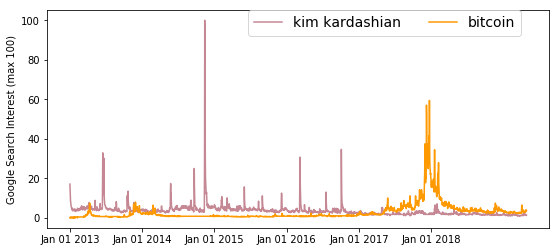

In [44]:
fig, ax1 = plt.subplots(1, 1, figsize=(9, 4))

ax1.set_xticks([datetime.date(j,1,1) for j in range(2013,2019)])
ax1.set_xticklabels([datetime.date(j,1,1).strftime('%b %d %Y') for j in range(2013,2019)])
for search_term, col in zip(['kim kardashian', 'bitcoin'], ('#C48793', '#FF9900')):
    ax1.plot(kim_btc_df['date'].dt.date, kim_btc_df[search_term], label=search_term, color=col)
ax1.set_ylabel('Google Search Interest (max 100)')    
ax1.legend(bbox_to_anchor=(0.4, 1), loc=2, borderaxespad=0., ncol=2, prop={'size': 14})
plt.show()

According to Google Trends, bitcoin became a more popular search term in June 2018 (a sure sign of a bubble if ever there was one- just realised this isn't a unique insight either). That said, Bitcoin has never reached the heights of Kim Kardashian on the 13th November 2014 (obviously, the day Kim Kardashian broke the internet). The graph shows daily values, but you'll notice that it quite closely matches what you'd get for the same weekly search on the Google Trends website.

While social metrics like reddit and google popularity can be powerful tools to study cryptocurrency prices, you may also want to incorporate data related to finance and the wider global economy.

So what's the future of cryptos? Moon, obviously! As for the future of cryptory, it already includes numerous tools that could improve price models (particularly, reddit and google trend metrics). But it's certainly lacking features that would take it to the moon:

twitter statistics (specifically John McAffee's!!!)
media analysis (number of mainstream articles, sentiment, etc.- example)
more Asian-centric data sources (Japan and South Korea are said to account for 40% and 20% of global bitcoin volume, respectively)
more financial/crypto data (integrate Quandl api)
In my next post, I'll use cryptory to (hopefully) improve the previous LSTM crypto price prediction model. While you wait for that, you can perform your own cryptocurrency analysis with the accompanying Jupyter notebook. Thanks for reading!